In [1]:
!pip install -U ultralytics --no-deps -q

import os
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.2 MB/s eta 0:00:00


In [2]:
import os
import shutil
import random
import cv2
import yaml
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from pathlib import Path
from tqdm.notebook import tqdm

# --- Configuration ---
SEED = 42
img_size = 640
conf_threshold_pseudo = 0.6  # High confidence threshold for pseudo-labels
device = 0 # '0' for GPU, 'cpu' for CPU

# Original Paths (Kaggle Input)
ORIG_TRAIN_IMG = '/kaggle/input/pillsegmentation/train/images'
ORIG_TRAIN_LBL = '/kaggle/input/pillsegmentation/train/labels'
ORIG_VAL_IMG = '/kaggle/input/pillsegmentation/valid/images'
ORIG_TEST_IMG = '/kaggle/input/pillsegmentation/test/images'

# Working Directory Paths
WORK_DIR = '/kaggle/working/dataset_ssl'
LABLED_DIR = os.path.join(WORK_DIR, 'labeled_20')
UNLABLED_DIR = os.path.join(WORK_DIR, 'unlabeled_80')
PSEUDO_DIR = os.path.join(WORK_DIR, 'pseudo_combined')

# Create Directories
for d in [LABLED_DIR, UNLABLED_DIR, PSEUDO_DIR]:
    os.makedirs(os.path.join(d, 'images'), exist_ok=True)
    os.makedirs(os.path.join(d, 'labels'), exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    # torch manual seed if imported

seed_everything(SEED)
print("Setup Complete.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Setup Complete.


In [3]:
import ultralytics
import cv2
import torch

print(f"Ultralytics Version: {ultralytics.__version__}")
print(f"OpenCV Version: {cv2.__version__}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")



Ultralytics Version: 8.3.237
OpenCV Version: 4.12.0
PyTorch Version: 2.6.0+cu124
CUDA Available: True


In [4]:
def preprocess_and_save(img_path, save_path):
    """Reads image, applies CLAHE (Contrast), saves to new location."""
    img = cv2.imread(img_path)
    if img is None: return False
    
    # Convert to LAB, apply CLAHE to L-channel
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    cv2.imwrite(save_path, final)
    return True

# --- Splitting Logic ---
all_train_images = sorted(glob.glob(os.path.join(ORIG_TRAIN_IMG, '*')))
random.shuffle(all_train_images)

split_idx = int(len(all_train_images) * 0.2) # 20% Labeled
labeled_imgs = all_train_images[:split_idx]
unlabeled_imgs = all_train_images[split_idx:]

print(f"Total Images: {len(all_train_images)}")
print(f"Labeled (Teacher Train): {len(labeled_imgs)}")
print(f"Unlabeled (For Pseudo): {len(unlabeled_imgs)}")

# 1. Process Labeled Data (20%)
print("Processing Labeled Data...")
for img_path in tqdm(labeled_imgs):
    basename = os.path.basename(img_path)
    lbl_name = basename.rsplit('.', 1)[0] + '.txt'
    src_lbl = os.path.join(ORIG_TRAIN_LBL, lbl_name)
    
    preprocess_and_save(img_path, os.path.join(LABLED_DIR, 'images', basename))
    if os.path.exists(src_lbl):
        shutil.copy(src_lbl, os.path.join(LABLED_DIR, 'labels', lbl_name))

# 2. Process Unlabeled Data (80%) - Images ONLY
print("Processing Unlabeled Data...")
for img_path in tqdm(unlabeled_imgs):
    basename = os.path.basename(img_path)
    preprocess_and_save(img_path, os.path.join(UNLABLED_DIR, 'images', basename))

Total Images: 6549
Labeled (Teacher Train): 1309
Unlabeled (For Pseudo): 5240
Processing Labeled Data...


  0%|          | 0/1309 [00:00<?, ?it/s]

Processing Unlabeled Data...


  0%|          | 0/5240 [00:00<?, ?it/s]

In [6]:
import glob

# 1. Clear any old YOLO cache files (Fixes corrupted index issues)
print("Clearing old cache files...")
for cache_file in glob.glob(os.path.join(LABLED_DIR, 'labels', '*.cache')):
    os.remove(cache_file)

# 2. Create Teacher YAML
teacher_yaml = {
    'path': WORK_DIR,
    'train': os.path.join(LABLED_DIR, 'images'),
    'val': ORIG_VAL_IMG,
    'test': ORIG_TEST_IMG,
    'names': {0: 'pill'} 
}
with open('teacher_data.yaml', 'w') as f:
    yaml.dump(teacher_yaml, f)

# 3. Train Teacher (Safe Mode)
print("--- Starting Teacher Training (20% Data) ---")
teacher_model = YOLO('yolov8s-seg.pt') 

teacher_results = teacher_model.train(
    data='teacher_data.yaml',
    epochs=30,
    imgsz=img_size,
    batch=16,
    patience=10,
    project='ssl_project',
    name='teacher_run',
    exist_ok=True,
    augment=True,
    
    # --- CRITICAL FIXES ---
    workers=0,      # Disable multiprocessing (Fixes DataLoader crash)
    cache=False,    # Disable RAM caching (Fixes buffer errors)
    amp=False,      # Disable AMP (Fixes GPU check crash)
    # ----------------------
    
    verbose=True
)
print("Teacher Training Finished.")

Clearing old cache files...
--- Starting Teacher Training (20% Data) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=teacher_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=teacher_run, nbs=64, nms=False, opset=None, optimize=False, o

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        598       3810      0.963       0.98      0.983      0.963      0.965      0.982      0.983      0.918
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/ssl_project/teacher_run
Teacher Training Finished.


In [7]:
print("--- Evaluating Teacher Performance on Test Set ---")

# Load best weights
best_teacher = YOLO('ssl_project/teacher_run/weights/best.pt')

# Run Validation on Test Split
metrics_t = best_teacher.val(data='teacher_data.yaml', split='test')

print("\n" + "="*40)
print(f"TEACHER RESULTS (20% Data Only):")
print(f"Mask mAP@0.5:      {metrics_t.seg.map50:.4f}")
print(f"Mask mAP@0.5:0.95: {metrics_t.seg.map:.4f}")
print("="*40 + "\n")


--- Evaluating Teacher Performance on Test Set ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 7.7±1.4 MB/s, size: 48.8 KB)
val: Scanning /kaggle/input/pillsegmentation/test/labels... 294 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 294/294 191.0it/s 1.5s0.1s
val: /kaggle/input/pillsegmentation/test/images/VAIPE_P_1130_2_jpg.rf.b85b72c13ee8a04ac9f370fb4da422b7.jpg: 1 duplicate labels removed
WARNING ⚠️ val: Cache directory /kaggle/input/pillsegmentation/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 3.3it/s 5.7s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        294       1781      0.976      0.965      0.984      0.969      0.975       0.97      0.987       0.92
Speed: 2.0ms preprocess, 6.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/runs/segment/val

TEACHER RESULTS (20% Data Only):
Mask mAP@0.5:      0.9874
Mask mAP@0.5:0.95: 0.9203



Checking Teacher Segmentations...


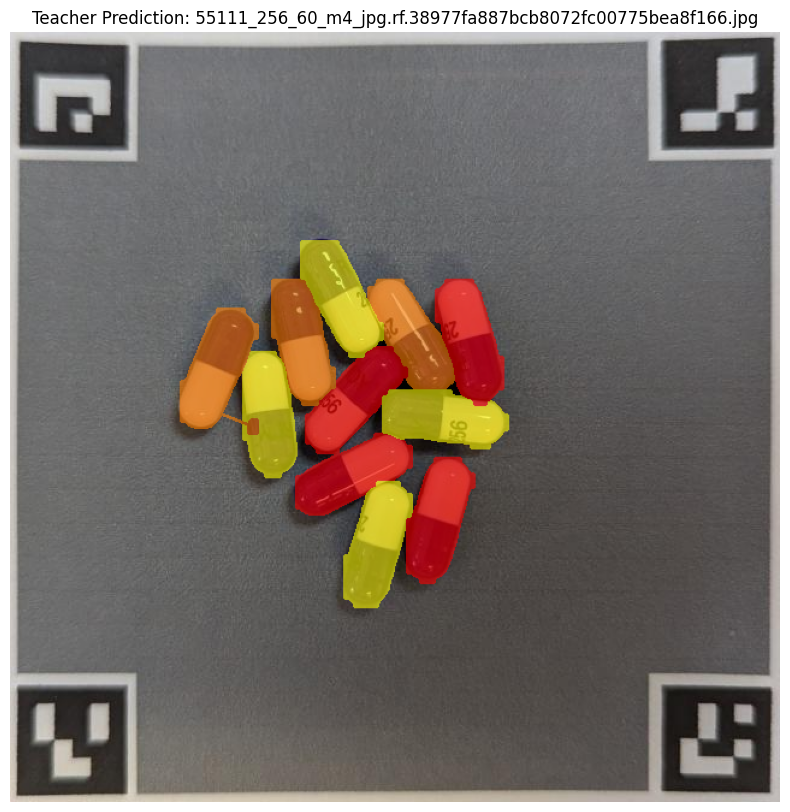

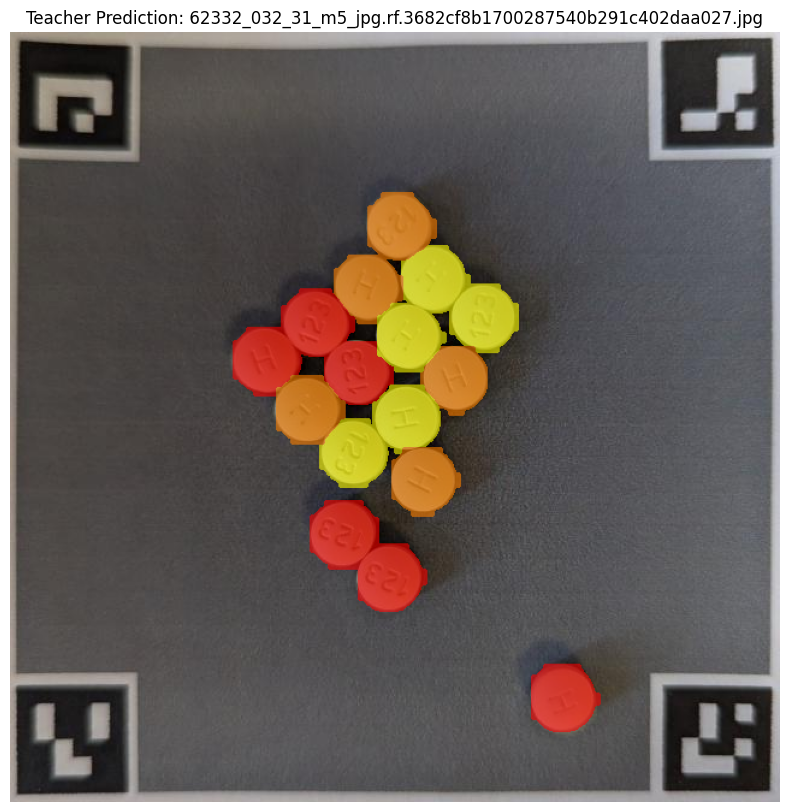

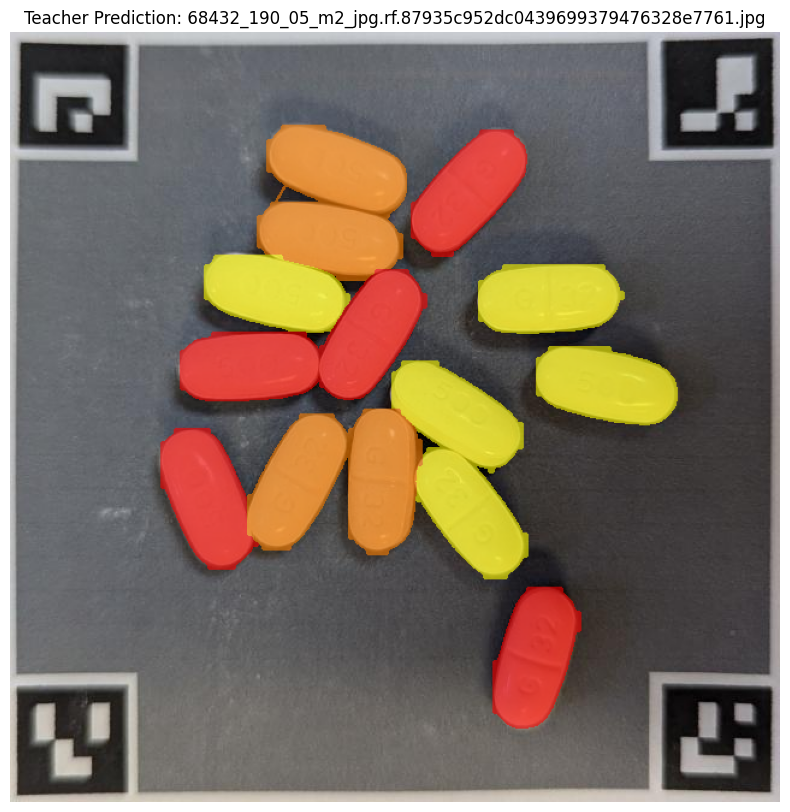

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
from ultralytics import YOLO

def plot_bright_masks(model, img_path, alpha=0.6):
    img = cv2.imread(img_path)
    if img is None: return
    
    # Run Prediction
    results = model.predict(img_path, verbose=False, conf=0.25)
    result = results[0]

    overlay = img.copy()
    
    # Red, Yellow, Orange Colors
    colors = [(0, 0, 255), (0, 255, 255), (0, 128, 255)]
    
    if result.masks is not None:
        for i, contour in enumerate(result.masks.xy):
            if len(contour) > 0:
                color = colors[i % len(colors)]
                cnt = contour.astype(np.int32).reshape((-1, 1, 2))
                cv2.fillPoly(overlay, [cnt], color)
                cv2.polylines(overlay, [cnt], isClosed=True, color=color, thickness=2)

        # Blend
        cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0, img)
        
        # Show
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Teacher Prediction: {os.path.basename(img_path)}")
        plt.axis('off')
        plt.show()
    else:
        print(f"⚠️ No masks found in {os.path.basename(img_path)}. (Only boxes or nothing)")

# --- Load TEACHER Model ---
print("Checking Teacher Segmentations...")
# Note: Changing path to 'teacher_run'
teacher_model = YOLO('ssl_project/teacher_run/weights/best.pt') 

# Test on 3 random images from the test set
test_images = glob.glob(os.path.join(ORIG_TEST_IMG, '*'))
samples = random.sample(test_images, 3)

for img_file in samples:
    plot_bright_masks(teacher_model, img_file)

In [9]:
print(f"--- Generating Pseudo Labels (Threshold: {conf_threshold_pseudo}) ---")

unlabeled_images_list = glob.glob(os.path.join(UNLABLED_DIR, 'images', '*'))
pseudo_count = 0

for img_path in tqdm(unlabeled_images_list):
    # Predict with High Confidence Threshold
    results = best_teacher.predict(img_path, conf=conf_threshold_pseudo, iou=0.7, verbose=False)
    result = results[0]
    
    # Prepare Save Path
    basename = os.path.basename(img_path)
    txt_name = basename.rsplit('.', 1)[0] + '.txt'
    save_path = os.path.join(UNLABLED_DIR, 'labels', txt_name)
    
    # If detections exist, save them
    if result.masks is not None:
        with open(save_path, 'w') as f:
            for i, box in enumerate(result.boxes):
                cls = int(box.cls[0])
                segments = result.masks.xyn[i] # Normalized Polygon
                
                # YOLO Format: class x1 y1 x2 y2 ...
                line = f"{cls} " + " ".join([f"{coord:.6f}" for coord in segments.flatten()])
                f.write(line + "\n")
        pseudo_count += 1

print(f"Pseudo-labeling complete. {pseudo_count}/{len(unlabeled_images_list)} images labeled.")

--- Generating Pseudo Labels (Threshold: 0.6) ---


  0%|          | 0/5240 [00:00<?, ?it/s]

Pseudo-labeling complete. 5164/5240 images labeled.


In [10]:
import glob
import os
import shutil
import yaml

# --- Re-define Paths (Safety check in case of kernel restart) ---
WORK_DIR = '/kaggle/working/dataset_ssl'
LABLED_DIR = os.path.join(WORK_DIR, 'labeled_20')
UNLABLED_DIR = os.path.join(WORK_DIR, 'unlabeled_80')
PSEUDO_DIR = os.path.join(WORK_DIR, 'pseudo_combined')

# Original Input Paths
ORIG_VAL_IMG = '/kaggle/input/pillsegmentation/valid/images'
ORIG_TEST_IMG = '/kaggle/input/pillsegmentation/test/images'

# Ensure directories exist
os.makedirs(os.path.join(PSEUDO_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(PSEUDO_DIR, 'labels'), exist_ok=True)

print("Merging datasets for Student...")

# 1. Copy Original Labeled (20%)
for img in glob.glob(os.path.join(LABLED_DIR, 'images', '*')):
    shutil.copy(img, os.path.join(PSEUDO_DIR, 'images'))
for lbl in glob.glob(os.path.join(LABLED_DIR, 'labels', '*')):
    shutil.copy(lbl, os.path.join(PSEUDO_DIR, 'labels'))

# 2. Copy Pseudo-Labeled Data (Only if label file exists and is not empty)
pseudo_lbls = glob.glob(os.path.join(UNLABLED_DIR, 'labels', '*'))

for lbl in pseudo_lbls:
    if os.path.getsize(lbl) > 0:
        basename = os.path.basename(lbl)
        # Find matching image
        img_name_search = glob.glob(os.path.join(UNLABLED_DIR, 'images', basename.rsplit('.', 1)[0] + '.*'))
        if img_name_search:
            src_img = img_name_search[0]
            shutil.copy(lbl, os.path.join(PSEUDO_DIR, 'labels'))
            shutil.copy(src_img, os.path.join(PSEUDO_DIR, 'images'))

print(f"Student Dataset Ready. Total images: {len(glob.glob(os.path.join(PSEUDO_DIR, 'images', '*')))}")

# Create Student YAML
student_yaml = {
    'path': WORK_DIR,
    'train': os.path.join(PSEUDO_DIR, 'images'),
    'val': ORIG_VAL_IMG,
    'test': ORIG_TEST_IMG,
    'names': {0: 'pill'}
}
with open('student_data.yaml', 'w') as f:
    yaml.dump(student_yaml, f)

Merging datasets for Student...
Student Dataset Ready. Total images: 6473


In [11]:
import gc
import torch

# 1. Delete old models from memory
print("Cleaning up GPU memory...")
if 'teacher_model' in globals():
    del teacher_model
if 'best_teacher' in globals():
    del best_teacher
if 'student_model' in globals():
    del student_model

# 2. Force Garbage Collection and Clear CUDA Cache
gc.collect()
torch.cuda.empty_cache()

# 3. Check Memory Status
print(f"GPU Memory Cleared. Allocated: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

Cleaning up GPU memory...
GPU Memory Cleared. Allocated: 7.05 GB


In [12]:
import glob
import os
from ultralytics import YOLO

print("--- Starting Student Training (Safe Memory Mode) ---")

# --- Configuration (Added here to fix NameError) ---
img_size = 640 
PSEUDO_DIR = '/kaggle/working/dataset_ssl/pseudo_combined'

# 1. Clear any old YOLO cache files (prevents errors if data changed)
for cache_file in glob.glob(os.path.join(PSEUDO_DIR, 'labels', '*.cache')):
    if os.path.exists(cache_file):
        os.remove(cache_file)

# 2. Load Student Model (Medium)
student_model = YOLO('yolov8m-seg.pt') 

# 3. Train Student
student_results = student_model.train(
    data='student_data.yaml',
    epochs=30,
    imgsz=img_size,  # Now defined above
    
    # --- MEMORY SAFETY SETTINGS ---
    batch=8,         # Set to 8
    workers=0,       # Fixes loader crashes
    amp=False,       # Fixes GPU sync crashes
    cache=False,     # Saves RAM
    # ------------------------------
    
    patience=15,
    project='ssl_project',
    name='student_run',
    exist_ok=True,
    augment=True,
    verbose=True
)
print("Student Training Finished.")

--- Starting Student Training (Safe Memory Mode) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=student_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=student_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        598       3810      0.966      0.973      0.978      0.939      0.967      0.974      0.979      0.894
Speed: 0.2ms preprocess, 14.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /kaggle/working/ssl_project/student_run
Student Training Finished.


--- Loading Best Weights for Evaluation ---

--- Calculating Metrics on Test Set (This may take a minute) ---
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,779,987 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.2±0.5 ms, read: 62.1±33.3 MB/s, size: 61.4 KB)
val: Scanning /kaggle/input/pillsegmentation/test/labels... 294 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 294/294 560.1it/s 0.5s0.0s
val: /kaggle/input/pillsegmentation/test/images/VAIPE_P_1130_2_jpg.rf.b85b72c13ee8a04ac9f370fb4da422b7.jpg: 1 duplicate labels removed
WARNING ⚠️ val: Cache directory /kaggle/input/pillsegmentation/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 3.5it/s 5.5s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        294       1781      0.976      0.965      0.984      0.969      0.975       0.97      0.987       0.92
Speed: 1.8ms preprocess, 6.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /kaggle/working/runs/segment/val6
Ultralytics 8.3.237 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8m-seg summary (fused): 105 layers, 27,222,963 parameters, 0 gradients
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 52.0±14.7 MB/s, size: 52.5 KB)
val: Scanning /kaggle/input/pillsegmentation/test/labels... 294 images, 4 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 294/294 761.5it/s 0.4s0.1s
val: /kaggle/input/pillsegmentation/test/images/VAIPE_P_1130_2_jpg.rf.b85b72c13ee8a04ac9f370fb4da422b7.jpg: 1 duplicate labels removed
WARNING ⚠️ val: Cache directory /kaggle/input/pillsegmentation/test is not writable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P   

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        294       1781      0.962      0.975       0.98      0.945      0.967      0.975      0.982      0.898
Speed: 1.7ms preprocess, 13.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /kaggle/working/runs/segment/val7

METRIC                    | TEACHER (20%)   | STUDENT (SSL)  
------------------------------------------------------------
mAP@0.5 (Mask)            | 0.9874          | 0.9821         
mAP@0.5:0.95 (Mask)       | 0.9203            | 0.8984         



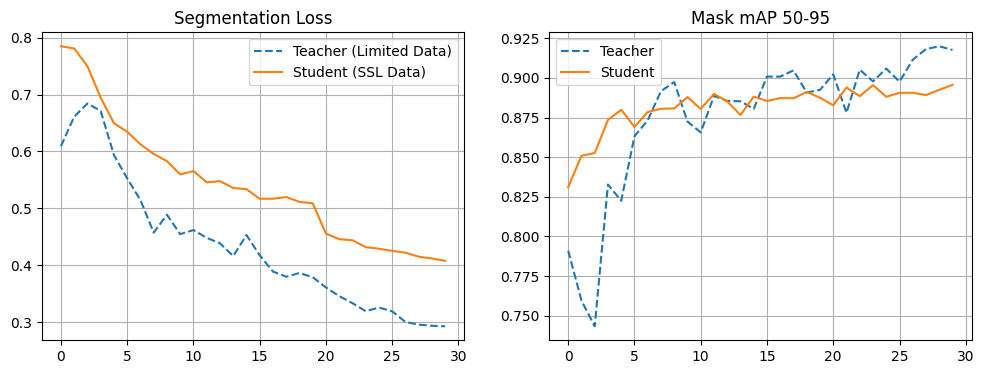

--- Visualizing Comparison: Teacher vs. Student (Masks Only) ---


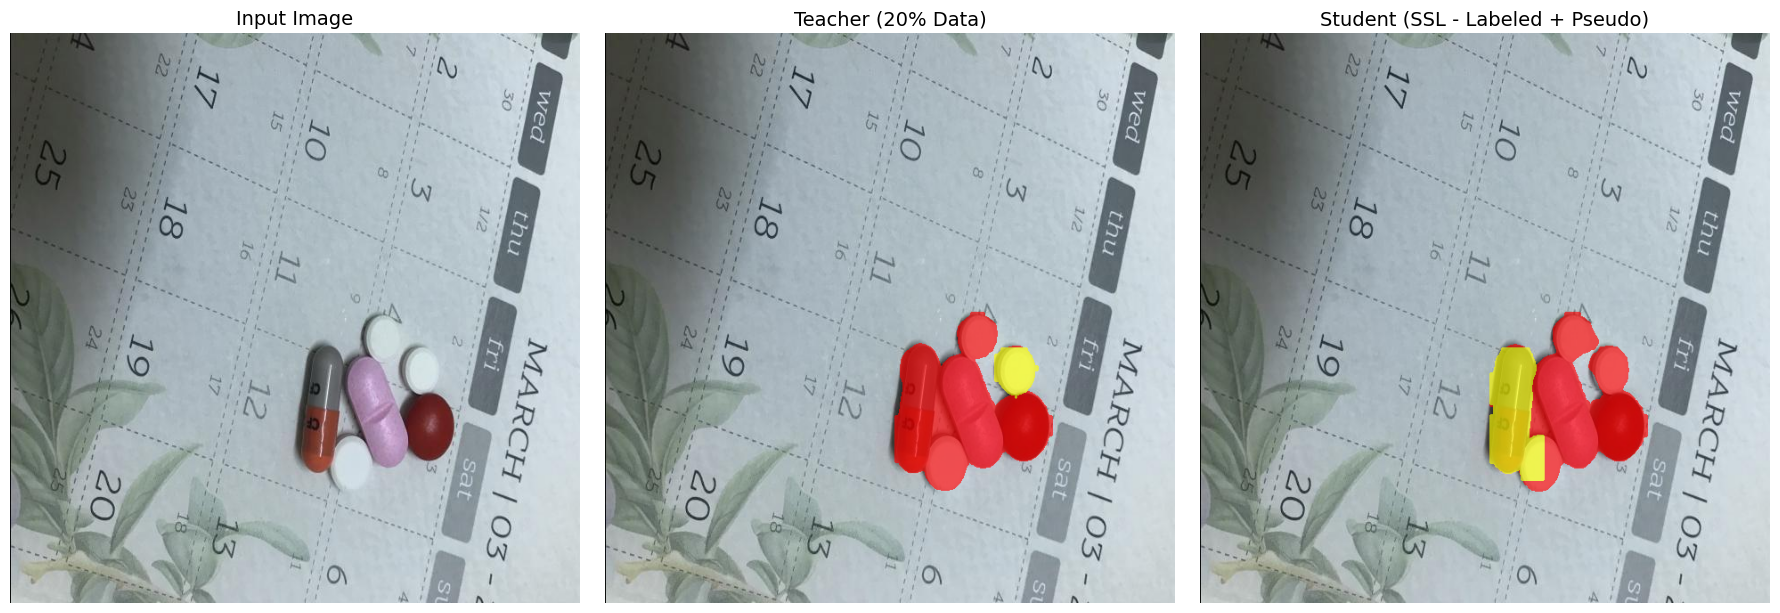

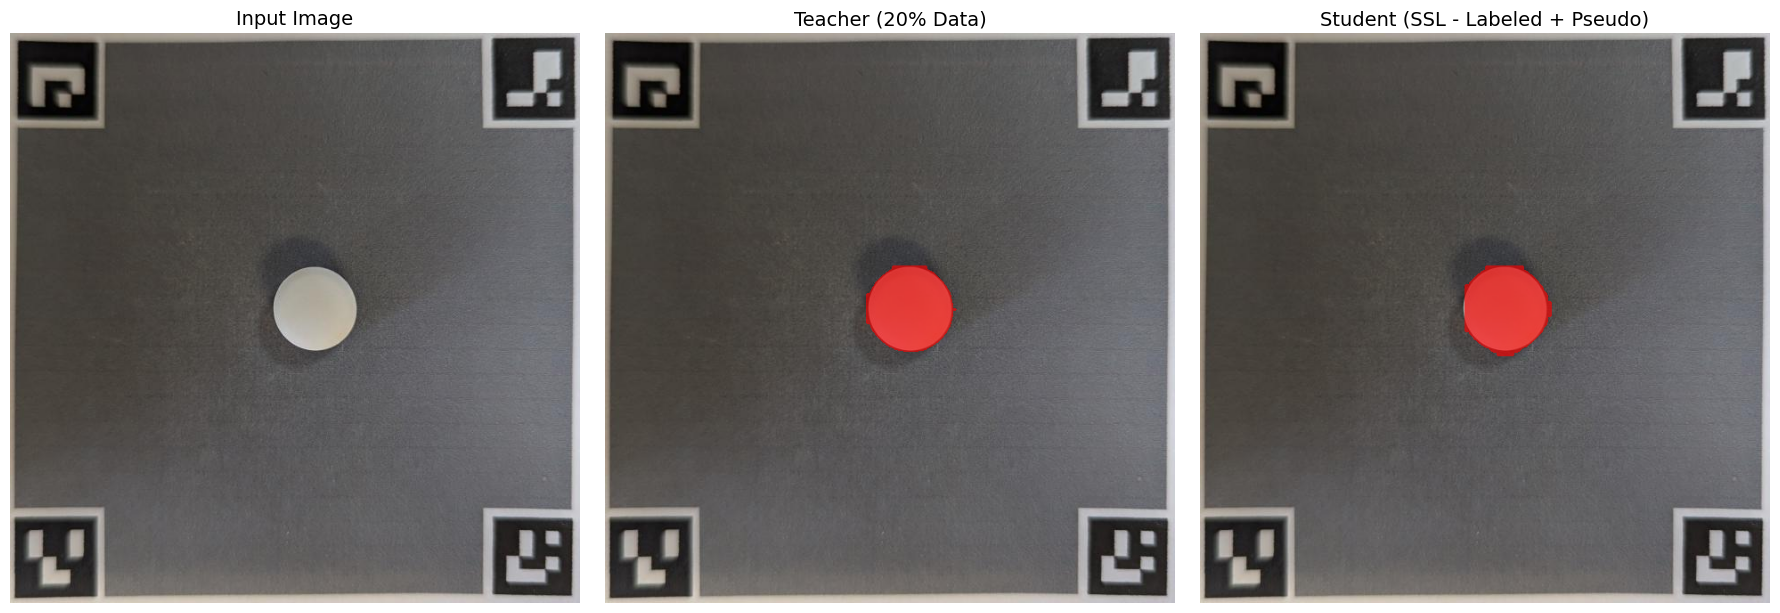

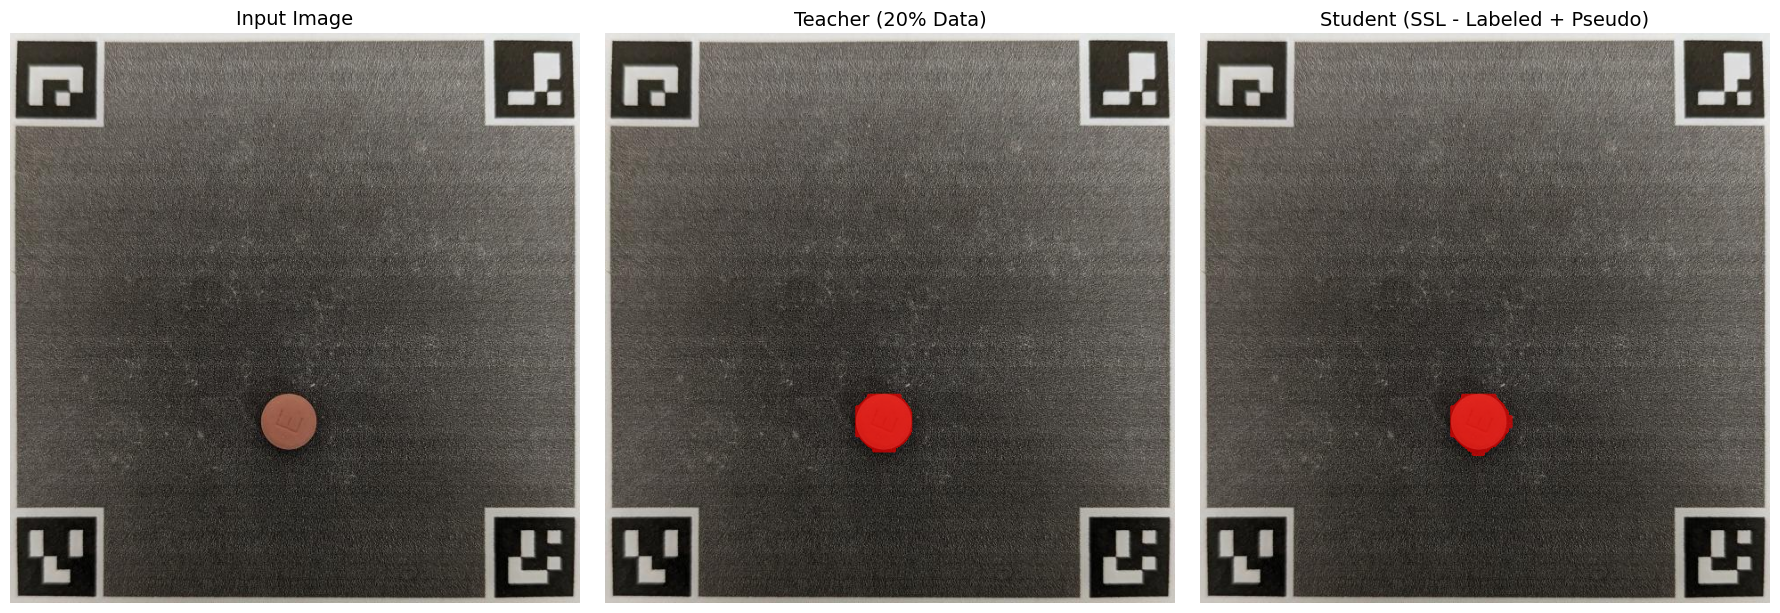

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cv2
import random
import numpy as np
from ultralytics import YOLO

# --- 1. Load Models & Calculate Metrics ---
print("--- Loading Best Weights for Evaluation ---")
best_teacher = YOLO('ssl_project/teacher_run/weights/best.pt')
best_student = YOLO('ssl_project/student_run/weights/best.pt')

print("\n--- Calculating Metrics on Test Set (This may take a minute) ---")
metrics_t = best_teacher.val(data='teacher_data.yaml', split='test', verbose=False)
metrics_s = best_student.val(data='student_data.yaml', split='test', verbose=False)

# --- 2. Print Comparison Table ---
print("\n" + "="*60)
print(f"{'METRIC':<25} | {'TEACHER (20%)':<15} | {'STUDENT (SSL)':<15}")
print("-" * 60)
print(f"{'mAP@0.5 (Mask)':<25} | {metrics_t.seg.map50:<15.4f} | {metrics_s.seg.map50:<15.4f}")
print(f"{'mAP@0.5:0.95 (Mask)':<25} | {metrics_t.seg.map:<15.4f}   | {metrics_s.seg.map:<15.4f}")
print("="*60 + "\n")

# --- 3. Plot Loss Curves ---
try:
    t_df = pd.read_csv('ssl_project/teacher_run/results.csv')
    s_df = pd.read_csv('ssl_project/student_run/results.csv')
    t_df.columns = t_df.columns.str.strip()
    s_df.columns = s_df.columns.str.strip()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(t_df['train/seg_loss'], label='Teacher (Limited Data)', linestyle='--')
    plt.plot(s_df['train/seg_loss'], label='Student (SSL Data)')
    plt.title('Segmentation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_df['metrics/mAP50-95(M)'], label='Teacher', linestyle='--')
    plt.plot(s_df['metrics/mAP50-95(M)'], label='Student')
    plt.title('Mask mAP 50-95')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Could not plot loss curves (files might be missing): {e}")

# --- 4. Custom Visualization Function (No Boxes, Bright Masks) ---
def get_colored_mask_image(model, img_path):
    img = cv2.imread(img_path)
    if img is None: return np.zeros((640,640,3), dtype=np.uint8)
    
    # Predict
    results = model.predict(img_path, verbose=False, conf=0.25)
    result = results[0]
    
    overlay = img.copy()
    
    # Bright Colors: Red, Yellow, Orange
    colors = [(0, 0, 255), (0, 255, 255), (0, 128, 255)]
    
    if result.masks is not None:
        for i, contour in enumerate(result.masks.xy):
            if len(contour) > 0:
                color = colors[i % len(colors)]
                cnt = contour.astype(np.int32).reshape((-1, 1, 2))
                
                # Fill Mask (No Box)
                cv2.fillPoly(overlay, [cnt], color)
                # Draw Outline
                cv2.polylines(overlay, [cnt], isClosed=True, color=color, thickness=2)
    
    # Blend with original image
    cv2.addWeighted(overlay, 0.65, img, 0.35, 0, img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# --- 5. Visual Comparison Loop ---
print("--- Visualizing Comparison: Teacher vs. Student (Masks Only) ---")
test_samples = glob.glob(os.path.join(ORIG_TEST_IMG, '*'))
samples = random.sample(test_samples, 3)

for img_path in samples:
    # Get original image
    orig_img = cv2.imread(img_path)
    orig_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    # Get predictions
    teacher_vis = get_colored_mask_image(best_teacher, img_path)
    student_vis = get_colored_mask_image(best_student, img_path)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(orig_rgb)
    axes[0].set_title("Input Image", fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(teacher_vis)
    axes[1].set_title("Teacher (20% Data)", fontsize=14)
    axes[1].axis('off')
    
    axes[2].imshow(student_vis)
    axes[2].set_title("Student (SSL - Labeled + Pseudo)", fontsize=14)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

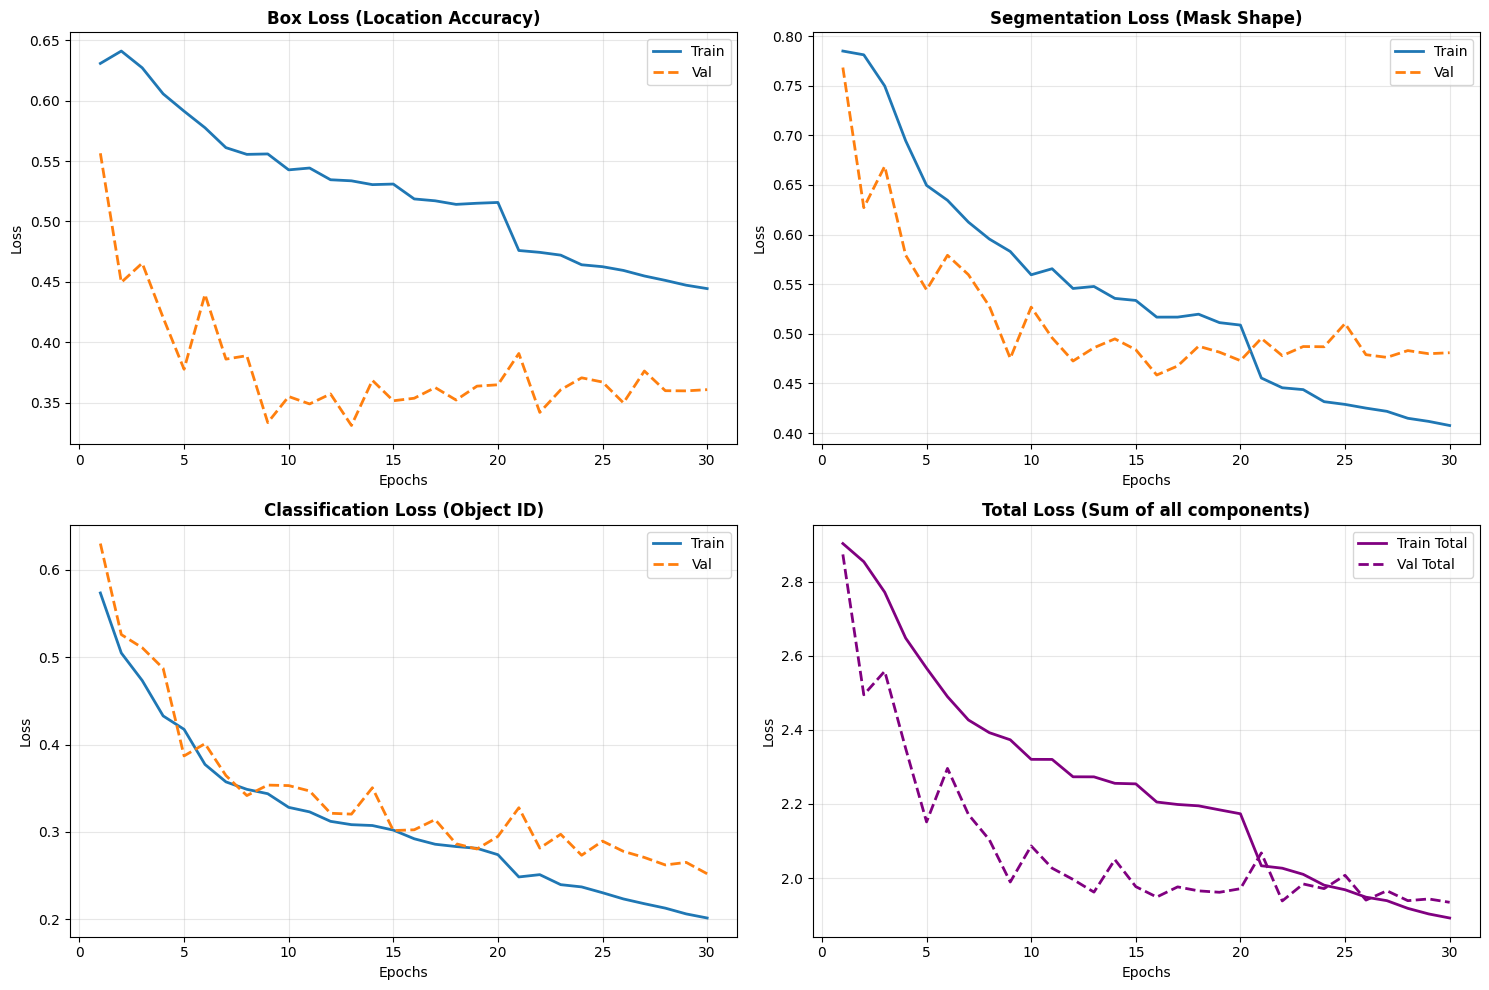

✅ Analysis:
Final Train Seg Loss: 0.4076
Final Val Seg Loss:   0.4809


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. Define the path to your Student results file
# Adjust 'student_run' if your folder name is different
results_path = 'ssl_project/student_run/results.csv'

if not os.path.exists(results_path):
    print(f"❌ Error: Could not find results file at {results_path}")
    print("Please check your folder name inside 'ssl_project/'")
else:
    # 2. Load Data
    df = pd.read_csv(results_path)
    
    # Clean column names (remove extra spaces)
    df.columns = df.columns.str.strip()
    
    # 3. Calculate Total Loss (Sum of components)
    # Note: YOLOv8 also uses DFL loss for boxes, we include it if present for accuracy
    train_components = ['train/box_loss', 'train/seg_loss', 'train/cls_loss']
    val_components = ['val/box_loss', 'val/seg_loss', 'val/cls_loss']
    
    if 'train/dfl_loss' in df.columns:
        train_components.append('train/dfl_loss')
        val_components.append('val/dfl_loss')

    df['train/total_loss'] = df[train_components].sum(axis=1)
    df['val/total_loss'] = df[val_components].sum(axis=1)

    # 4. Plotting
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    epochs = range(1, len(df) + 1)

    # Helper function to plot
    def plot_metric(ax, metric_name, title):
        if f'train/{metric_name}' in df.columns:
            ax.plot(epochs, df[f'train/{metric_name}'], label='Train', linewidth=2)
        if f'val/{metric_name}' in df.columns:
            ax.plot(epochs, df[f'val/{metric_name}'], label='Val', linewidth=2, linestyle='--')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # --- Plot 1: Box Loss (Bounding Box accuracy) ---
    plot_metric(axes[0, 0], 'box_loss', 'Box Loss (Location Accuracy)')

    # --- Plot 2: Segmentation Loss (Mask accuracy) ---
    plot_metric(axes[0, 1], 'seg_loss', 'Segmentation Loss (Mask Shape)')

    # --- Plot 3: Classification Loss (What object is it?) ---
    plot_metric(axes[1, 0], 'cls_loss', 'Classification Loss (Object ID)')

    # --- Plot 4: Total Loss ---
    axes[1, 1].plot(epochs, df['train/total_loss'], label='Train Total', color='purple', linewidth=2)
    axes[1, 1].plot(epochs, df['val/total_loss'], label='Val Total', color='purple', linestyle='--', linewidth=2)
    axes[1, 1].set_title('Total Loss (Sum of all components)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✅ Analysis:")
    print(f"Final Train Seg Loss: {df['train/seg_loss'].iloc[-1]:.4f}")
    print(f"Final Val Seg Loss:   {df['val/seg_loss'].iloc[-1]:.4f}")